In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import os


In [2]:

# Set paths
from pathlib import Path
# Current working directory (assumes notebook is run from project root)
SCRIPT_DIR = Path.cwd()
DATASET_ROOT = SCRIPT_DIR / 'Image' / '4'

train_path = os.path.join(DATASET_ROOT, "train")
val_path = os.path.join(DATASET_ROOT, "val")
test_path = os.path.join(DATASET_ROOT, "test")
save_dir = "./misclassified"
os.makedirs(save_dir, exist_ok=True)

# Config
IMG_SIZE = 84
BATCH_SIZE = 64
NUM_CLASSES = 33
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# Enhanced transforms for training data
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Applying different transforms to different datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

img_tensor, lbl=train_dataset[0]
print(img_tensor.shape,lbl)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(train_dataset.class_to_idx)


torch.Size([3, 84, 84]) 0
{'Ibizan_hound': 0, 'aircraft_carrier': 1, 'beer_bottle': 2, 'bolete': 3, 'boxer': 4, 'carton': 5, 'dome': 6, 'electric_guitar': 7, 'file': 8, 'french_bulldog': 9, 'garbage_truck': 10, 'golden_retriever': 11, 'gordon_setter': 12, 'hair_slide': 13, 'hourglass': 14, 'house_finch': 15, 'komondor': 16, 'malamute': 17, 'meerkat': 18, 'pencil_box': 19, 'prayer_rug': 20, 'reel': 21, 'rock_beauty': 22, 'scoreboard': 23, 'solar_dish': 24, 'stage': 25, 'street_sign': 26, 'tank': 27, 'tile_roof': 28, 'tobacco_shop': 29, 'trifle': 30, 'white_wolf': 31, 'yawl': 32}


In [4]:
# CNN Model
class CustomCNN(nn.Module):
    def __init__(self, conv_config, fc_config, num_classes, use_maxpool=True, stride=1, 
                 use_batchnorm=True, use_dropout=True, dropout_rate=0.5):  # Add new parameters
        super(CustomCNN, self).__init__()
        layers = []
        in_channels = 3
        for i, out_channels in enumerate(conv_config):
            s = stride[i] if isinstance(stride, list) else stride
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=s, padding=1))
            if use_batchnorm:  # Make BatchNorm optional
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            if use_maxpool:
                layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = out_channels
        
        self.conv = nn.Sequential(*layers)

        # Compute output size after conv layers
        conv_output_size = IMG_SIZE
        for i in range(len(conv_config)):
            s = stride[i] if isinstance(stride, list) else stride
            conv_output_size //= s
            if use_maxpool:
                conv_output_size //= 2
        flatten_dim = in_channels * conv_output_size * conv_output_size
        
        fc_layers = []
        for fc in fc_config:
            fc_layers.append(nn.Linear(flatten_dim, fc))
            fc_layers.append(nn.ReLU())
            if use_dropout:  # Make dropout optional
                fc_layers.append(nn.Dropout(p=dropout_rate))
            flatten_dim = fc
        fc_layers.append(nn.Linear(flatten_dim, num_classes))
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Train Function
def train_model(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

# Eval Function
def evaluate_model(model, loader, criterion, save_misclassified=False, run_name=""):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

            if save_misclassified:
                wrong = preds != labels
                wrong_images = images[wrong]
                wrong_preds = preds[wrong]
                wrong_labels = labels[wrong]
                for idx in range(len(wrong_images)):
                    img = transforms.ToPILImage()(wrong_images[idx].cpu())
                    img.save(f"{save_dir}/{run_name}_true_{wrong_labels[idx].item()}_pred_{wrong_preds[idx].item()}_{i}_{idx}.png")

    avg_loss = total_loss / len(loader.dataset)
    accuracy = 100 * correct / len(loader.dataset)
    return avg_loss, accuracy

In [5]:

# Experiment Runner
results = []


In [6]:

def run_experiment(conv_layers, fc_layers, use_maxpool, stride, epochs, run_name="model", 
                   use_batchnorm=True, use_dropout=True, dropout_rate=0.5,
                   save_misclassified=False):
    model = CustomCNN(conv_layers, fc_layers, NUM_CLASSES, use_maxpool, stride,
                     use_batchnorm, use_dropout, dropout_rate).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_train_loss = float("inf")
    best_val_loss = float("inf")
    best_test_loss = float("inf")
    best_val_acc = 0
    best_test_acc = 0

    start = time.time()
    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        best_train_loss = min(best_train_loss, train_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
    end = time.time()

    test_loss, test_acc = evaluate_model(model, test_loader, criterion, save_misclassified=save_misclassified, run_name=run_name)
    best_test_loss = test_loss
    best_test_acc = test_acc

    print(f"\n===== Final Results =====")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")
    print(f"Training time: {round(end - start, 2)} seconds")
    print("=======================\n")
    
    results.append({
        "run_name": run_name,
        "conv_layers": str(conv_layers),
        "fc_layers": str(fc_layers),
        "maxpool": use_maxpool,
        "stride": stride,
        "epochs": epochs,
        "best_train_loss": best_train_loss,
        "best_val_loss": best_val_loss,
        "best_val_acc": best_val_acc,
        "test_loss": best_test_loss,
        "test_acc": best_test_acc,
        "time_sec": round(end - start, 2)
    })


In [ ]:
run_experiment(
    conv_layers=[64, 128, 256, 512, 512],
    fc_layers=[1024, 512],
    use_maxpool=True,
    stride=1,
    epochs=1,
    use_batchnorm=False,  # Disable BatchNorm
    use_dropout=False,    # Disable Dropout
    save_misclassified=False,
    run_name="no Norm"
)

In [7]:
run_experiment(
    conv_layers=[64, 128, 256, 512, 512],
    fc_layers=[1024, 512],
    use_maxpool=True,
    stride=1,
    epochs=80,
    run_name="increasedEpochs"
)

Epoch 1/80 - Train Loss: 3.2455 | Val Loss: 3.1685 | Val Acc: 12.52%
Epoch 2/80 - Train Loss: 2.9301 | Val Loss: 3.1398 | Val Acc: 14.79%
Epoch 3/80 - Train Loss: 2.7060 | Val Loss: 2.7112 | Val Acc: 23.33%
Epoch 4/80 - Train Loss: 2.5409 | Val Loss: 2.5680 | Val Acc: 27.33%
Epoch 5/80 - Train Loss: 2.4058 | Val Loss: 2.4368 | Val Acc: 30.58%
Epoch 6/80 - Train Loss: 2.2644 | Val Loss: 2.2801 | Val Acc: 34.79%
Epoch 7/80 - Train Loss: 2.1476 | Val Loss: 2.1439 | Val Acc: 38.15%
Epoch 8/80 - Train Loss: 2.0741 | Val Loss: 2.0858 | Val Acc: 40.21%
Epoch 9/80 - Train Loss: 1.9925 | Val Loss: 2.0209 | Val Acc: 41.73%
Epoch 10/80 - Train Loss: 1.8790 | Val Loss: 2.4612 | Val Acc: 34.39%
Epoch 11/80 - Train Loss: 1.8191 | Val Loss: 1.8652 | Val Acc: 47.15%
Epoch 12/80 - Train Loss: 1.7365 | Val Loss: 2.1755 | Val Acc: 41.12%
Epoch 13/80 - Train Loss: 1.6664 | Val Loss: 2.1383 | Val Acc: 42.09%
Epoch 14/80 - Train Loss: 1.5994 | Val Loss: 1.8605 | Val Acc: 47.58%
Epoch 15/80 - Train Loss: 1.5

In [8]:
results_df = pd.DataFrame(results)
print(results_df)

          run_name               conv_layers    fc_layers  maxpool  stride  \
0  increasedEpochs  [64, 128, 256, 512, 512]  [1024, 512]     True       1   

   epochs  best_train_loss  best_val_loss  best_val_acc  test_loss   test_acc  \
0      80         0.263405        1.53954     60.060606   1.843714  64.545455   

   time_sec  
0   2726.52  


In [9]:
csv_path = "custom_cnn_experiment_results.csv"

# If file exists, append without duplicating header
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    combined_df = pd.concat([existing_df, results_df], ignore_index=True)
    combined_df.to_csv(csv_path, index=False)
else:
    results_df.to_csv(csv_path, index=False)


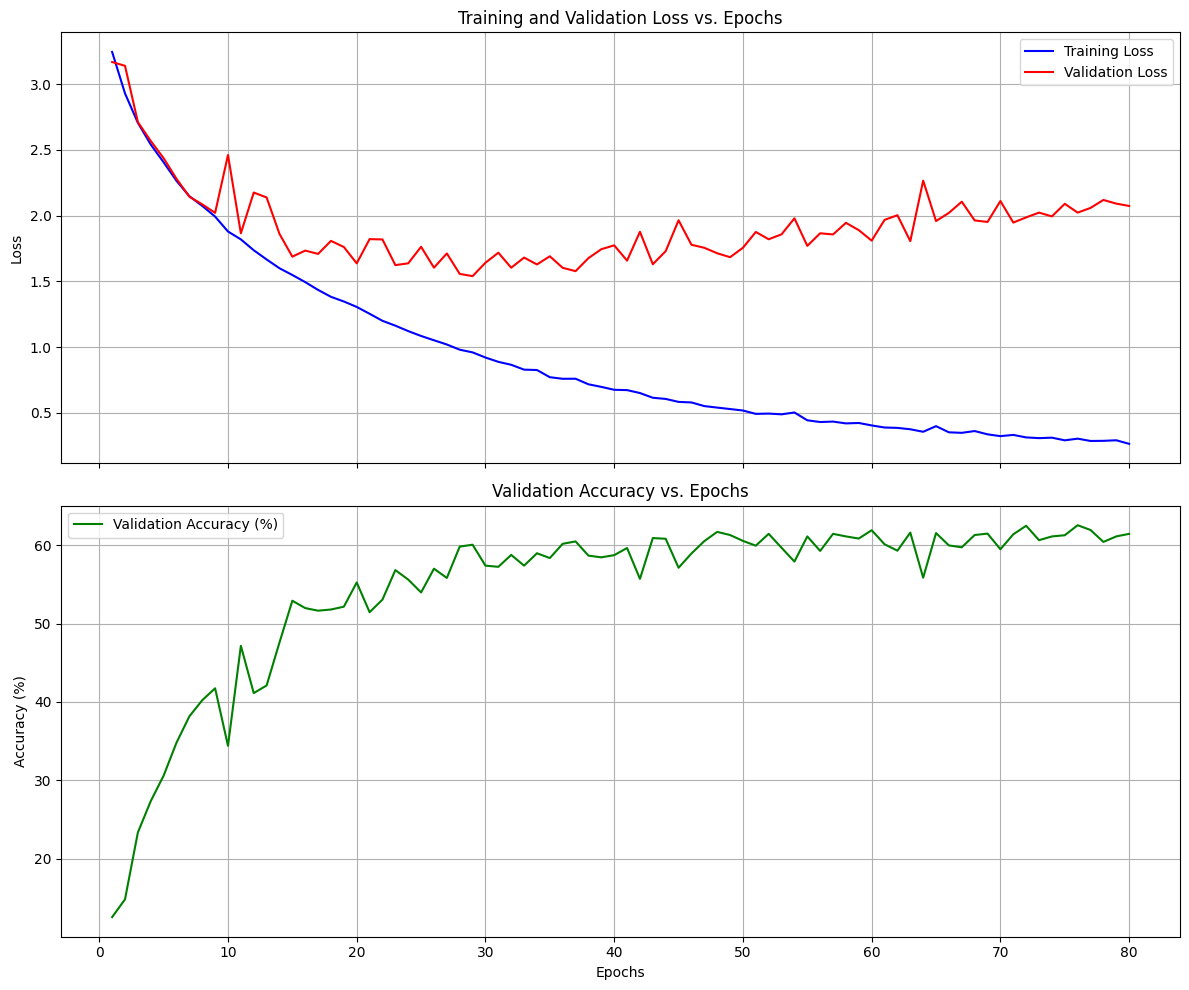

Initial train loss: 3.2455, Final train loss: 0.2634
Initial val loss: 3.1685, Final val loss: 2.0735
Initial val accuracy: 12.52%, Final val accuracy: 61.45%
Best validation accuracy: 62.55% (Epoch 76)
Best validation loss: 1.5395 (Epoch 29)


In [10]:
# Create a new cell with this code
import matplotlib.pyplot as plt
import numpy as np
import re

# Extract data from log output
log_lines = """
Epoch 1/80 - Train Loss: 3.2455 | Val Loss: 3.1685 | Val Acc: 12.52%
Epoch 2/80 - Train Loss: 2.9301 | Val Loss: 3.1398 | Val Acc: 14.79%
Epoch 3/80 - Train Loss: 2.7060 | Val Loss: 2.7112 | Val Acc: 23.33%
Epoch 4/80 - Train Loss: 2.5409 | Val Loss: 2.5680 | Val Acc: 27.33%
Epoch 5/80 - Train Loss: 2.4058 | Val Loss: 2.4368 | Val Acc: 30.58%
Epoch 6/80 - Train Loss: 2.2644 | Val Loss: 2.2801 | Val Acc: 34.79%
Epoch 7/80 - Train Loss: 2.1476 | Val Loss: 2.1439 | Val Acc: 38.15%
Epoch 8/80 - Train Loss: 2.0741 | Val Loss: 2.0858 | Val Acc: 40.21%
Epoch 9/80 - Train Loss: 1.9925 | Val Loss: 2.0209 | Val Acc: 41.73%
Epoch 10/80 - Train Loss: 1.8790 | Val Loss: 2.4612 | Val Acc: 34.39%
Epoch 11/80 - Train Loss: 1.8191 | Val Loss: 1.8652 | Val Acc: 47.15%
Epoch 12/80 - Train Loss: 1.7365 | Val Loss: 2.1755 | Val Acc: 41.12%
Epoch 13/80 - Train Loss: 1.6664 | Val Loss: 2.1383 | Val Acc: 42.09%
Epoch 14/80 - Train Loss: 1.5994 | Val Loss: 1.8605 | Val Acc: 47.58%
Epoch 15/80 - Train Loss: 1.5481 | Val Loss: 1.6876 | Val Acc: 52.91%
Epoch 16/80 - Train Loss: 1.4939 | Val Loss: 1.7339 | Val Acc: 51.97%
Epoch 17/80 - Train Loss: 1.4345 | Val Loss: 1.7087 | Val Acc: 51.64%
Epoch 18/80 - Train Loss: 1.3820 | Val Loss: 1.8077 | Val Acc: 51.79%
Epoch 19/80 - Train Loss: 1.3466 | Val Loss: 1.7610 | Val Acc: 52.15%
Epoch 20/80 - Train Loss: 1.3052 | Val Loss: 1.6369 | Val Acc: 55.24%
Epoch 21/80 - Train Loss: 1.2530 | Val Loss: 1.8211 | Val Acc: 51.45%
Epoch 22/80 - Train Loss: 1.1995 | Val Loss: 1.8185 | Val Acc: 53.06%
Epoch 23/80 - Train Loss: 1.1626 | Val Loss: 1.6234 | Val Acc: 56.82%
Epoch 24/80 - Train Loss: 1.1213 | Val Loss: 1.6369 | Val Acc: 55.61%
Epoch 25/80 - Train Loss: 1.0841 | Val Loss: 1.7628 | Val Acc: 53.97%
Epoch 26/80 - Train Loss: 1.0515 | Val Loss: 1.6038 | Val Acc: 57.00%
Epoch 27/80 - Train Loss: 1.0193 | Val Loss: 1.7122 | Val Acc: 55.82%
Epoch 28/80 - Train Loss: 0.9797 | Val Loss: 1.5564 | Val Acc: 59.82%
Epoch 29/80 - Train Loss: 0.9593 | Val Loss: 1.5395 | Val Acc: 60.06%
Epoch 30/80 - Train Loss: 0.9201 | Val Loss: 1.6415 | Val Acc: 57.39%
Epoch 31/80 - Train Loss: 0.8874 | Val Loss: 1.7178 | Val Acc: 57.24%
Epoch 32/80 - Train Loss: 0.8648 | Val Loss: 1.6035 | Val Acc: 58.76%
Epoch 33/80 - Train Loss: 0.8279 | Val Loss: 1.6807 | Val Acc: 57.39%
Epoch 34/80 - Train Loss: 0.8250 | Val Loss: 1.6284 | Val Acc: 58.97%
Epoch 35/80 - Train Loss: 0.7704 | Val Loss: 1.6906 | Val Acc: 58.36%
Epoch 36/80 - Train Loss: 0.7583 | Val Loss: 1.6028 | Val Acc: 60.18%
Epoch 37/80 - Train Loss: 0.7588 | Val Loss: 1.5774 | Val Acc: 60.48%
Epoch 38/80 - Train Loss: 0.7164 | Val Loss: 1.6765 | Val Acc: 58.67%
Epoch 39/80 - Train Loss: 0.6968 | Val Loss: 1.7445 | Val Acc: 58.45%
Epoch 40/80 - Train Loss: 0.6746 | Val Loss: 1.7735 | Val Acc: 58.73%
Epoch 41/80 - Train Loss: 0.6722 | Val Loss: 1.6574 | Val Acc: 59.64%
Epoch 42/80 - Train Loss: 0.6499 | Val Loss: 1.8772 | Val Acc: 55.70%
Epoch 43/80 - Train Loss: 0.6140 | Val Loss: 1.6300 | Val Acc: 60.91%
Epoch 44/80 - Train Loss: 0.6051 | Val Loss: 1.7296 | Val Acc: 60.82%
Epoch 45/80 - Train Loss: 0.5825 | Val Loss: 1.9646 | Val Acc: 57.12%
Epoch 46/80 - Train Loss: 0.5784 | Val Loss: 1.7782 | Val Acc: 58.94%
Epoch 47/80 - Train Loss: 0.5506 | Val Loss: 1.7551 | Val Acc: 60.52%
Epoch 48/80 - Train Loss: 0.5392 | Val Loss: 1.7135 | Val Acc: 61.70%
Epoch 49/80 - Train Loss: 0.5281 | Val Loss: 1.6834 | Val Acc: 61.30%
Epoch 50/80 - Train Loss: 0.5170 | Val Loss: 1.7553 | Val Acc: 60.55%
Epoch 51/80 - Train Loss: 0.4914 | Val Loss: 1.8756 | Val Acc: 59.94%
Epoch 52/80 - Train Loss: 0.4936 | Val Loss: 1.8199 | Val Acc: 61.45%
Epoch 53/80 - Train Loss: 0.4880 | Val Loss: 1.8576 | Val Acc: 59.67%
Epoch 54/80 - Train Loss: 0.5019 | Val Loss: 1.9793 | Val Acc: 57.91%
Epoch 55/80 - Train Loss: 0.4425 | Val Loss: 1.7698 | Val Acc: 61.12%
Epoch 56/80 - Train Loss: 0.4293 | Val Loss: 1.8656 | Val Acc: 59.27%
Epoch 57/80 - Train Loss: 0.4327 | Val Loss: 1.8566 | Val Acc: 61.45%
Epoch 58/80 - Train Loss: 0.4189 | Val Loss: 1.9450 | Val Acc: 61.12%
Epoch 59/80 - Train Loss: 0.4221 | Val Loss: 1.8893 | Val Acc: 60.85%
Epoch 60/80 - Train Loss: 0.4034 | Val Loss: 1.8097 | Val Acc: 61.91%
Epoch 61/80 - Train Loss: 0.3876 | Val Loss: 1.9672 | Val Acc: 60.12%
Epoch 62/80 - Train Loss: 0.3848 | Val Loss: 2.0031 | Val Acc: 59.30%
Epoch 63/80 - Train Loss: 0.3742 | Val Loss: 1.8055 | Val Acc: 61.61%
Epoch 64/80 - Train Loss: 0.3552 | Val Loss: 2.2664 | Val Acc: 55.85%
Epoch 65/80 - Train Loss: 0.3979 | Val Loss: 1.9585 | Val Acc: 61.55%
Epoch 66/80 - Train Loss: 0.3510 | Val Loss: 2.0209 | Val Acc: 59.97%
Epoch 67/80 - Train Loss: 0.3472 | Val Loss: 2.1058 | Val Acc: 59.73%
Epoch 68/80 - Train Loss: 0.3607 | Val Loss: 1.9633 | Val Acc: 61.30%
Epoch 69/80 - Train Loss: 0.3357 | Val Loss: 1.9518 | Val Acc: 61.48%
Epoch 70/80 - Train Loss: 0.3219 | Val Loss: 2.1111 | Val Acc: 59.48%
Epoch 71/80 - Train Loss: 0.3313 | Val Loss: 1.9471 | Val Acc: 61.39%
Epoch 72/80 - Train Loss: 0.3122 | Val Loss: 1.9864 | Val Acc: 62.48%
Epoch 73/80 - Train Loss: 0.3068 | Val Loss: 2.0228 | Val Acc: 60.64%
Epoch 74/80 - Train Loss: 0.3103 | Val Loss: 1.9940 | Val Acc: 61.12%
Epoch 75/80 - Train Loss: 0.2901 | Val Loss: 2.0899 | Val Acc: 61.27%
Epoch 76/80 - Train Loss: 0.3028 | Val Loss: 2.0229 | Val Acc: 62.55%
Epoch 77/80 - Train Loss: 0.2853 | Val Loss: 2.0585 | Val Acc: 61.94%
Epoch 78/80 - Train Loss: 0.2862 | Val Loss: 2.1192 | Val Acc: 60.42%
Epoch 79/80 - Train Loss: 0.2905 | Val Loss: 2.0912 | Val Acc: 61.12%
Epoch 80/80 - Train Loss: 0.2634 | Val Loss: 2.0735 | Val Acc: 61.45%
"""

# Extract train loss, validation loss and accuracy
train_losses = []
val_losses = []
val_accs = []
epochs = []

# Process each line to extract information
for line in log_lines.strip().split('\n'):
    match = re.search(r"Epoch (\d+)/\d+ - Train Loss: (\d+\.\d+) \| Val Loss: (\d+\.\d+) \| Val Acc: (\d+\.\d+)", line)
    if match:
        epoch = int(match.group(1))
        train_loss = float(match.group(2))
        val_loss = float(match.group(3))
        val_acc = float(match.group(4))
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

# Create figure with two subplots: one for losses, one for accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot the losses
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss vs. Epochs')
ax1.legend()
ax1.grid(True)

# Plot the validation accuracy
ax2.plot(epochs, val_accs, 'g-', label='Validation Accuracy (%)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy vs. Epochs')
ax2.legend()
ax2.grid(True)

# Add some margins to the figure
plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300)
plt.show()

# Print statistics
print(f"Initial train loss: {train_losses[0]:.4f}, Final train loss: {train_losses[-1]:.4f}")
print(f"Initial val loss: {val_losses[0]:.4f}, Final val loss: {val_losses[-1]:.4f}")
print(f"Initial val accuracy: {val_accs[0]:.2f}%, Final val accuracy: {val_accs[-1]:.2f}%")
print(f"Best validation accuracy: {max(val_accs):.2f}% (Epoch {epochs[val_accs.index(max(val_accs))]})")
print(f"Best validation loss: {min(val_losses):.4f} (Epoch {epochs[val_losses.index(min(val_losses))]})")